在Prepare the Data之前，训练集、测试集先分开探索处理；之后再整合到一起处理成vector;

决定还是一块处理比较好，否则需要进行两次探索，有的可能在测试集有取值，训练集中没有等等。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

from scipy.stats import norm,skew
import scipy.stats as stats

pandas The default NaN recognized values are 

['-1.#IND', '1.#QNAN', '1.#IND', '-1.#QNAN', '#N/A','N/A', 'NA', '#NA', 'NULL', 'NaN', '-NaN', 'nan', '-nan']

`pandas`会把‘NA’字符串值当做NAN处理，而不是默认的没有，eg：PoolQC NA意味着没有泳池。

In [2]:
train_df = pd.read_csv('./input/train.csv')
test_df = pd.read_csv('./input/test.csv')

#train1 = pd.read_csv('./input/train.csv',na_filter=False)
#na_filter参数False默认处理数据集都不为空，没有缺失；不会对'NA'值进行处理

train = train_df.copy()
test = test_df.copy()

### Explore the Data

数据探索过程：

1. Study each attribute and its characteristics:
    - Name
    - Type(categorical, int/float, bounded/unbounded,text,structured,etc.)
    - % if missing values
    - Noisiness and type of noise(stochastic, outliers, rounding errors,etc.)
    - Possibly useful for the task?
    - Type of distribution(Gaussian, uniform, logarithmic,etc).

2. For supervised learning tasks, identify the target attribute(s).
3. Visualize the data.
4. Study the correlations between attributes.
5. Study how you would solve the problem manually.
6. Identify the promising transformations you may want to apply.
7. Identify extra data that would be useful.
8. Document what you have learned.

EDA，即探索性数据分析（Exploratory Data Analysis），是指对已有的数据(特别是调查或观察得来的原始数据)在尽量少的先验假定下进行探索，通过作图、制表、方程拟合、计算特征量等手段探索数据的结构和规律的一种数据分析方法。

**主要是发现数据特征[符合分布，最值]，数据存在的问题[缺失、离群点etc]，以及可能对数据的处理**


In [3]:
print('Training set shape:',train.shape)
print('Testing set shape:', test.shape)

Training set shape: (1460, 81)
Testing set shape: (1459, 80)


In [4]:
data = pd.concat([train,test],axis=0)

In [5]:
data.drop(['Id','SalePrice'],inplace=True,axis=1)

In [6]:
data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


In [7]:
data.describe()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,OverallCond,OverallQual,PoolArea,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
count,2919.000000,2919.000000,2919.000000,2919.000000,2918.000000,2918.000000,2917.000000,2917.000000,2918.000000,2919.000000,...,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,1159.581706,336.483727,2.602261,2.860226,441.423235,49.582248,0.429894,0.061364,560.772104,23.098321,...,5.564577,6.089072,2.251799,16.062350,6.451524,1051.777587,93.709832,1971.312778,1984.264474,2007.792737
std,392.362079,428.701456,25.188169,0.822693,455.610826,169.205611,0.524736,0.245687,439.543659,64.244246,...,1.113131,1.409947,35.663946,56.184365,1.569379,440.766258,126.526589,30.291442,20.894344,1.314964
min,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1872.000000,1950.000000,2006.000000
25%,876.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,220.000000,0.000000,...,5.000000,5.000000,0.000000,0.000000,5.000000,793.000000,0.000000,1953.500000,1965.000000,2007.000000
50%,1082.000000,0.000000,0.000000,3.000000,368.500000,0.000000,0.000000,0.000000,467.000000,0.000000,...,5.000000,6.000000,0.000000,0.000000,6.000000,989.500000,0.000000,1973.000000,1993.000000,2008.000000
75%,1387.500000,704.000000,0.000000,3.000000,733.000000,0.000000,1.000000,0.000000,805.500000,0.000000,...,6.000000,7.000000,0.000000,0.000000,7.000000,1302.000000,168.000000,2001.000000,2004.000000,2009.000000
max,5095.000000,2065.000000,508.000000,8.000000,5644.000000,1526.000000,3.000000,2.000000,2336.000000,1012.000000,...,9.000000,10.000000,800.000000,576.000000,15.000000,6110.000000,1424.000000,2010.000000,2010.000000,2010.000000


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 79 columns):
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
Alley            198 non-null object
BedroomAbvGr     2919 non-null int64
BldgType         2919 non-null object
BsmtCond         2837 non-null object
BsmtExposure     2837 non-null object
BsmtFinSF1       2918 non-null float64
BsmtFinSF2       2918 non-null float64
BsmtFinType1     2840 non-null object
BsmtFinType2     2839 non-null object
BsmtFullBath     2917 non-null float64
BsmtHalfBath     2917 non-null float64
BsmtQual         2838 non-null object
BsmtUnfSF        2918 non-null float64
CentralAir       2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
Electrical       2918 non-null object
EnclosedPorch    2919 non-null int64
ExterCond        2919 non-null object
ExterQual        2919 non-null object
Exterior1st      291

还是先看看数据集的缺失情况吧，之后再深入数据。

标签`SalePrice`没有缺失！

数据特征是在太多了，在了解特征之前，由于处理的问题是一个supervised learning任务，所以先看看标签值SalePrice

先看看标签`SalePrice`有没有缺失？

In [9]:
train['SalePrice'].isnull().sum()

0

`SalePrice`没有缺失；再画图看看分布情况

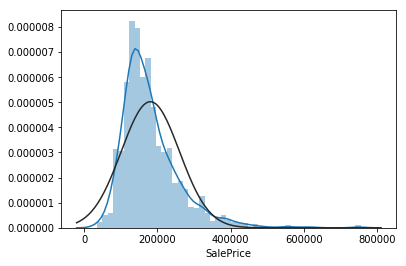

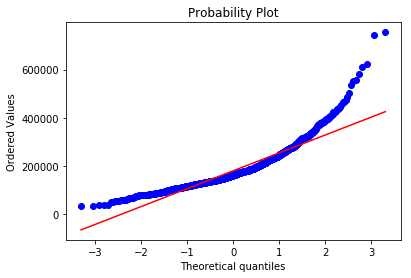

In [10]:
# sns distplot 直方图，比pandas的plot.hist功能要更强大
#标签数据SalePrice直方图分布;黑色为随机变量的正态分布情况；对比可以发现：标签数据发生右偏
sns.distplot(a=train['SalePrice'],fit=norm)
fig = plt.figure()#创建一个画布
res = stats.probplot(train['SalePrice'], plot=plt)

通过直方图以及正太概率图，发现数据并不符合正态分布；从直方图中的蓝线还可以看出，数据发生右偏。

正态概率图：用来检测数据是否符合正态分布。理想情况是红线所示[一条直线].

*总是期望数据符合**正态分布**，将标签数据转换成正态分布。*

In [11]:
loglabels = np.log1p(train['SalePrice'])# y = log(1+x) 防止log后为0；对应exp1m

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([10.46027076, 10.47197813, 10.54273278, ..., 13.34550853,
         13.52114084, 13.53447435])),
 (0.398259646654151, 12.024057394918403, 0.9953761551826702))

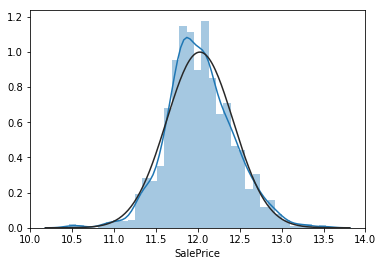

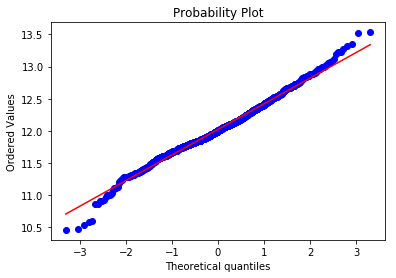

In [12]:
sns.distplot(a=loglabels,fit=norm)
fig = plt.figure()
stats.probplot(loglabels,plot=plt)

处理后的SalePrice标签基本符合正态分布。

接下来探索数据特征...

由于数据特征太多，可以对数据特征进行分类，分出Numeric和categorical特征；不同的特征处理方法又有所不同。

In [13]:
a = data.isnull().sum()
b = a[a>0].sort_values(ascending=False)
c = (a[a>0]/len(data)).sort_values(ascending=False)

# 需要先指定keys，再指定names，否则指定names不管用
df = pd.concat([b,c],axis=1,keys=['Total', 'Percent'])
df

,Total,Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageQual,159,0.054471
GarageCond,159,0.054471
GarageFinish,159,0.054471
GarageYrBlt,159,0.054471


In [14]:
data.columns

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Alley', 'BedroomAbvGr',
       'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'Exterior1st',
       'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation',
       'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'GrLivArea',
       'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenAbvGr',
       'KitchenQual', 'LandContour', 'LandSlope', 'LotArea', 'LotConfig',
       'LotFrontage', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning',
       'MasVnrArea', 'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold',
       'Neighborhood', 'OpenPorchSF', 'OverallCond', 'OverallQual',
       'PavedDrive', 'PoolArea', 'PoolQC',

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 79 columns):
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
Alley            198 non-null object
BedroomAbvGr     2919 non-null int64
BldgType         2919 non-null object
BsmtCond         2837 non-null object
BsmtExposure     2837 non-null object
BsmtFinSF1       2918 non-null float64
BsmtFinSF2       2918 non-null float64
BsmtFinType1     2840 non-null object
BsmtFinType2     2839 non-null object
BsmtFullBath     2917 non-null float64
BsmtHalfBath     2917 non-null float64
BsmtQual         2838 non-null object
BsmtUnfSF        2918 non-null float64
CentralAir       2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
Electrical       2918 non-null object
EnclosedPorch    2919 non-null int64
ExterCond        2919 non-null object
ExterQual        2919 non-null object
Exterior1st      291

依据数据描述文件，先对数据集特征进行类别划分，文本类型or数值类型；依据大类型再对特征进行整合，之后根据整合后的特征集进行数据探索。

In [16]:
cateFeats = data.select_dtypes(include=[object]).columns # object文本类型数据
numFeats = data.select_dtypes(include=[np.float64,np.int64]).columns

print('trainset features length:{},\ncateFeats features length:{}, \nnumFeats features length:{}'.format(len(data.columns),\
     len(cateFeats),len(numFeats)))

trainset features length:79,
cateFeats features length:43, 
numFeats features length:36


数据集特征划分为两类：文本类型[应该为类别型数据categorical]，数字型数据[连续数据]；

不同类型数据探索方式不同，相应的数据处理方法也有所不同。

### 探索文本类型数据

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
  'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
  'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
  'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
  'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
  'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
  'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
  'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
  'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
  
 特征划分[依据描述实体类型不同]：
 1. 关于房子本身的特征[材料等等]：
'LotShape'，BldgType，HouseStyle，RoofStyle，RoofMatl，Exterior1st，
Exterior2nd，MasVnrType，ExterQual，ExterCond，Foundation，BsmtQual，BsmtCond，BsmtExposure，BsmtFinType1，
BsmtFinType2，KitchenQual，FireplaceQu，GarageType，GarageFinish，GarageQual，GarageCond，PavedDrive，Fence，
SaleType，SaleCondition

 2. 房子周边[地理信息等]：
'MSZoning'，'Street'，'Alley'，'LandContour'，LandSlope，Neighborhood，Condition1，Condition2，
 
 3. 房子功能性[娱乐，加热等等]：
Utilities，LotConfig，Heating，HeatingQC，Electrical，CentralAir，Functional，PoolQC，MiscFeature

In [17]:
cateFeats

Index(['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd',
       'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC',
       'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig',
       'LotShape', 'MSZoning', 'MasVnrType', 'MiscFeature', 'Neighborhood',
       'PavedDrive', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition',
       'SaleType', 'Street', 'Utilities'],
      dtype='object')

In [18]:
def missingRatio(df,col):
    print('{} missing ratio is:{}'.format(col, df[col].isnull().sum()/len(df)))

1. MSSubClass

类别型数据，int64转成str

train['MSSubClass'] = train['MSSubClass'].apply(str)

看各个值的分布，看看直方图分布。

train['MSSubClass'].value_counts().sort_values(ascending=False)

train['MSSubClass'].value_counts().plot.bar()

missingRatio(train,'MSSubClass')

*MSSubClass特征没有缺失，属于categorical特征，处理方法：直接使用LabelEncoder编码*

missingRatio(test,'MSSubClass')

In [20]:
def barplot(df, col):
    (df[col].value_counts()/len(df)).sort_index().plot.bar()

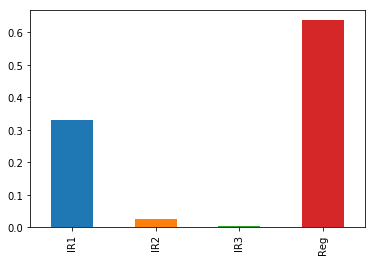

In [21]:
#LotShape
barplot(data,'LotShape')

In [22]:
missingRatio(data,'LotShape')

LotShape missing ratio is:0.0


1. MSZoning

标识销售的一般分区分类 String categorical

In [23]:
data['MSZoning'].value_counts().sort_values(ascending=False)

RL         2265
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

In [24]:
missingRatio(data,'MSZoning')

MSZoning missing ratio is:0.0013703323055841042


缺失：类别型数据；

填充策略[处理方法]: 使用众数(中位数)填充；

2. BldgType

住宅类型 categorical

In [25]:
missingRatio(data,'BldgType')

BldgType missing ratio is:0.0


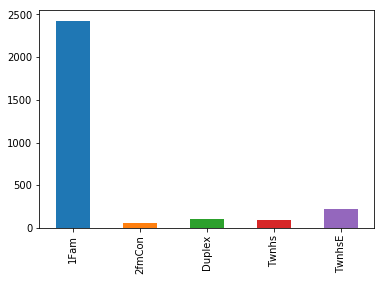

In [26]:
data['BldgType'].value_counts().sort_index().plot.bar()

3. HouseStyle

categorical

In [27]:
missingRatio(data,'HouseStyle')

HouseStyle missing ratio is:0.0


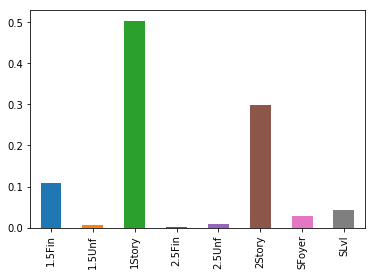

In [28]:
barplot(data,'HouseStyle')

4. RoofStyle

屋顶类型 categorical

In [29]:
missingRatio(data,'RoofStyle')

RoofStyle missing ratio is:0.0


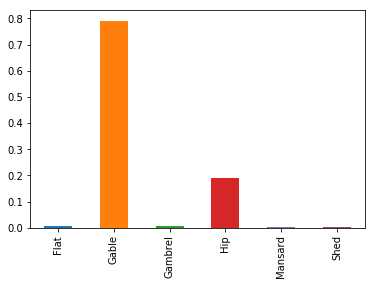

In [30]:
barplot(data,'RoofStyle')

3. RoofMatl

屋顶类型 categorical

In [31]:
missingRatio(data,'RoofMatl')

RoofMatl missing ratio is:0.0


4. Exterior1st Exterior2nd

categorical

In [32]:
missingRatio(data,'Exterior1st')

Exterior1st missing ratio is:0.00034258307639602604


In [33]:
missingRatio(data,'Exterior2nd')

Exterior2nd missing ratio is:0.00034258307639602604


In [34]:
data[data['Exterior1st'].isnull()|data['Exterior2nd'].isnull()][['Exterior1st','Exterior2nd']]

,Exterior1st,Exterior2nd
691,NaN,NaN


处理方法：只有一条记录缺失

填充法:使用中位数[众数]填充

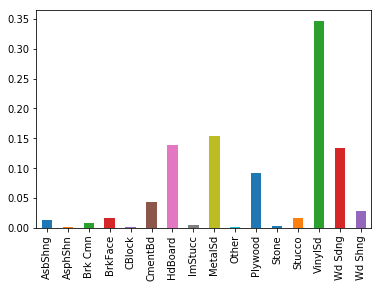

In [35]:
barplot(data,'Exterior2nd')

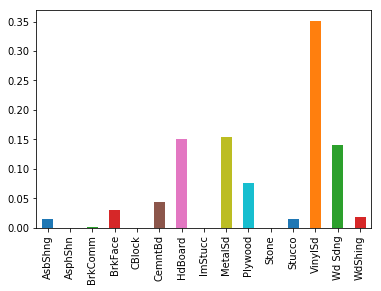

In [36]:
barplot(data,'Exterior1st')

5. MasVnrType

categorical

In [37]:
missingRatio(data,'MasVnrType')

MasVnrType missing ratio is:0.008221993833504625


In [38]:
#看看缺失的记录
data[data['MasVnrType'].isnull()]

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
234,860,1100,0,NaN,4,1Fam,TA,No,625.0,0.0,...,WD,0,Pave,8,860.0,AllPub,288,2002,2002,2010
529,2515,0,0,NaN,4,1Fam,TA,No,1219.0,0.0,...,WD,0,Pave,9,2035.0,AllPub,0,1957,1975,2007
650,822,843,0,NaN,3,1Fam,TA,No,0.0,0.0,...,WD,0,Pave,7,813.0,AllPub,0,2007,2007,2008
936,1200,0,0,NaN,2,1Fam,TA,No,833.0,0.0,...,WD,0,Pave,5,1176.0,AllPub,0,2003,2003,2009
973,1428,0,0,NaN,3,1Fam,TA,No,0.0,0.0,...,New,0,Pave,6,1428.0,AllPub,0,2007,2008,2008
977,1241,0,0,Pave,1,TwnhsE,TA,No,1106.0,0.0,...,New,0,Pave,4,1241.0,AllPub,0,2006,2007,2007
1243,2076,0,0,NaN,2,1Fam,Gd,Gd,1386.0,0.0,...,New,0,Pave,7,2076.0,AllPub,216,2006,2006,2006
1278,1128,903,0,NaN,3,1Fam,TA,No,804.0,0.0,...,WD,0,Pave,7,1128.0,AllPub,0,2002,2002,2008
231,878,1126,0,NaN,4,1Fam,TA,No,651.0,0.0,...,WD,0,Pave,8,870.0,AllPub,0,2002,2002,2009
246,1436,0,0,NaN,3,1Fam,TA,No,0.0,0.0,...,New,0,Pave,6,1436.0,AllPub,0,2008,2009,2009


一共24条记录缺失，可以使用‘None’填充

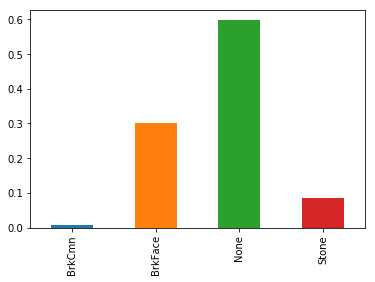

In [39]:
barplot(data,'MasVnrType')

6. ExterQual ExterCond

ordinal 序列型类别；有大小关系；LabelEncoder

In [40]:
missingRatio(data,'ExterQual')

ExterQual missing ratio is:0.0


In [41]:
missingRatio(data,'ExterCond')

ExterCond missing ratio is:0.0


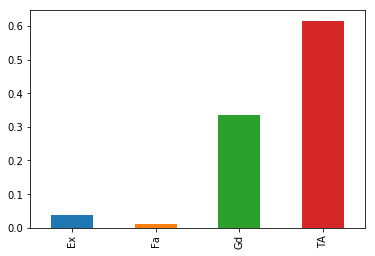

In [42]:
barplot(data,'ExterQual')

没有`Po`取值？？？看看各个值的统计情况

In [43]:
data['ExterQual'].value_counts().sort_values(ascending=False)

TA    1798
Gd     979
Ex     107
Fa      35
Name: ExterQual, dtype: int64

缺失没有`Po`取值，说明条件都挺好的。

Ordinal数据 LabelEncoder

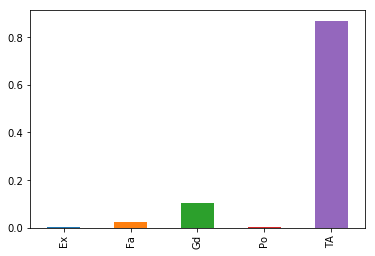

In [44]:
barplot(data,'ExterCond')

7. Foundation

基础类型 categorical 

In [45]:
missingRatio(data,'Foundation')

Foundation missing ratio is:0.0


没有缺失；
直接使用onehot编码

8. BsmtQual，BsmtCond，BsmtExposure，BsmtFinType1，BsmtFinType2

都属于ordinal， 使用onehot编码

In [46]:
missingRatio(data,'BsmtQual')

BsmtQual missing ratio is:0.02774922918807811


In [47]:
missingRatio(data,'BsmtCond')

BsmtCond missing ratio is:0.028091812264474134


In [48]:
missingRatio(data,'BsmtExposure')

BsmtExposure missing ratio is:0.028091812264474134


In [49]:
missingRatio(data,'BsmtFinType1')

BsmtFinType1 missing ratio is:0.027064063035286058


In [50]:
missingRatio(data,'BsmtFinType2')

BsmtFinType2 missing ratio is:0.027406646111682084


五个特征都有缺失，具体查看缺失的记录

In [51]:
data[data['BsmtQual'].isnull()|data['BsmtCond'].isnull()|data['BsmtExposure'].isnull()|\
     data['BsmtFinType1'].isnull()|data['BsmtFinType2'].isnull()]

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
17,1296,0,0,NaN,2,Duplex,NaN,NaN,0.0,0.0,...,WD,0,Pave,6,0.0,AllPub,0,1967,1967,2006
39,1152,0,0,NaN,2,Duplex,NaN,NaN,0.0,0.0,...,WD,0,Pave,6,0.0,AllPub,0,1955,1955,2008
90,1040,0,0,NaN,2,1Fam,NaN,NaN,0.0,0.0,...,WD,0,Pave,4,0.0,AllPub,0,1950,1950,2006
102,1535,0,0,NaN,4,Duplex,NaN,NaN,0.0,0.0,...,WD,0,Pave,8,0.0,AllPub,0,1979,1979,2009
156,1040,0,0,NaN,2,1Fam,NaN,NaN,0.0,0.0,...,WD,0,Pave,5,0.0,AllPub,0,1950,1950,2006
182,1340,0,180,NaN,3,1Fam,NaN,NaN,0.0,0.0,...,WD,0,Pave,7,0.0,AllPub,116,1957,2006,2007
259,882,0,0,NaN,2,1Fam,NaN,NaN,0.0,0.0,...,WD,0,Pave,4,0.0,AllPub,0,1956,1956,2008
332,1629,0,0,NaN,3,1Fam,TA,No,1124.0,479.0,...,WD,0,Pave,7,3206.0,AllPub,0,2003,2004,2009
342,1040,0,0,NaN,2,Duplex,NaN,NaN,0.0,0.0,...,WD,0,Pave,6,0.0,AllPub,0,1949,1950,2006
362,495,1427,0,NaN,4,1Fam,NaN,NaN,0.0,0.0,...,ConLD,0,Pave,7,0.0,AllPub,0,2003,2003,2009


有一种可能是不是pandas把‘NA’有意义的取值，看做空缺值NA了？？？

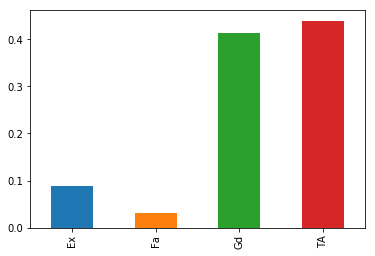

In [52]:
barplot(data,'BsmtQual')

从上面的条形图中可以看出：BsmtQual特征只有4个取值，而数据描述中有NA：No Basement;所以pandas将NA取值看做了空缺标识；

处理方法：将NA替换为‘None’,然后再用categorical，onehot编码

9. KitchenQual，FireplaceQu

ordinal， None填充

In [53]:
missingRatio(data,'KitchenQual')

KitchenQual missing ratio is:0.00034258307639602604


In [54]:
missingRatio(data,'FireplaceQu')

FireplaceQu missing ratio is:0.48646796848235696


处理方法和BsmtQual相同，先用None替换NA,然后再类别编码

10. GarageType，GarageFinish，GarageQual，GarageCond

GarageType： categorical， None填充，one-hot

GarageFinish：ordinal，None填充，LabelEncoder

GarageQual：ordinal，None填充，LabelEncoder

GarageCond：ordinal，None填充，LabelEncoder

In [55]:
missingRatio(data,'GarageType')

GarageType missing ratio is:0.05378554299417609


这几个特征的缺失主要是因为pandas对‘NA’取值的错误理解，可以通过将NA替换成‘None’解决。

10. PavedDrive，SaleType，SaleCondition

PavedDrive：categorical 

SaleType：categorical,缺失，众数填充

SaleCondition：categorical，

In [56]:
missingRatio(data,'PavedDrive')

PavedDrive missing ratio is:0.0


In [57]:
missingRatio(data,'SaleType')

SaleType missing ratio is:0.00034258307639602604


In [58]:
data[data['SaleType'].isnull()]

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
1029,1176,0,0,NaN,3,1Fam,TA,Mn,190.0,873.0,...,NaN,0,Pave,6,1158.0,AllPub,0,1958,1998,2007


In [59]:
missingRatio(data,'SaleCondition')

SaleCondition missing ratio is:0.0


11. Fence
Fence： ordinal ，NA替换None

In [60]:
missingRatio(data,'Fence')

Fence missing ratio is:0.8043850633778691


In [61]:
data['Fence'].value_counts()

MnPrv    329
GdPrv    118
GdWo     112
MnWw      12
Name: Fence, dtype: int64

#### 房子周边特征分析

1. MSZoning

categorical 

In [62]:
missingRatio(data,'MSZoning')

MSZoning missing ratio is:0.0013703323055841042


In [63]:
data[data['MSZoning'].isnull()]

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
455,810,0,0,NaN,1,1Fam,NaN,NaN,0.0,0.0,...,ConLD,0,Grvl,4,0.0,NaN,119,1910,1950,2009
756,733,0,0,NaN,2,1Fam,NaN,NaN,0.0,0.0,...,WD,0,Pave,4,0.0,AllPub,0,1952,1952,2008
790,1150,686,0,NaN,4,1Fam,TA,No,0.0,0.0,...,WD,0,Pave,7,686.0,AllPub,0,1900,1950,2008
1444,1600,0,0,NaN,3,1Fam,NaN,NaN,0.0,0.0,...,WD,0,Pave,6,0.0,AllPub,0,1951,1951,2006


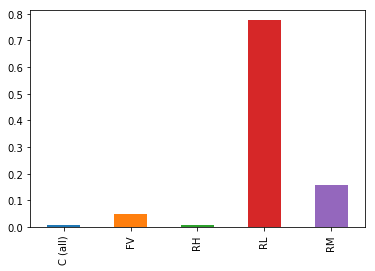

In [64]:
barplot(data,'MSZoning')

使用众数[中位数]填充

2. Street，

Street：categorical，one-hot编码


In [65]:
missingRatio(data,'Street')

Street missing ratio is:0.0


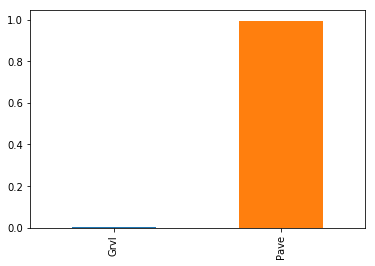

In [66]:
barplot(data,'Street')

In [67]:
data['Street'].value_counts().sort_values(ascending=False)

Pave    2907
Grvl      12
Name: Street, dtype: int64

我还以为只有一个取值，如果是只有一个取值，那么可以直接删掉这个特征。

3. Alley

Alley： categorical，None填充

In [68]:
missingRatio(data,'Alley')

Alley missing ratio is:0.9321685508735869


缺失率有点高啊，但是由于‘NA’是有意义的取值。所以用‘None’填充。

4. 'LandContour'，LandSlope

LandContour：one-hot编码

LandSlope：one-hot编码

In [69]:
missingRatio(data,'LandContour')

LandContour missing ratio is:0.0


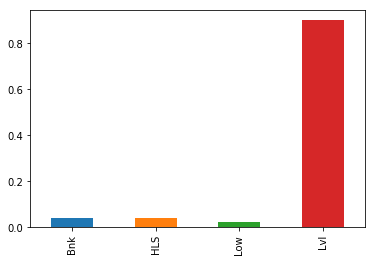

In [70]:
barplot(data,'LandContour')

In [71]:
missingRatio(data,'LandSlope')

LandSlope missing ratio is:0.0


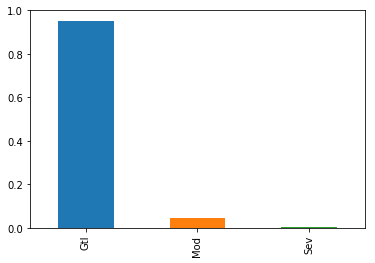

In [72]:
barplot(data,'LandSlope')

5. Neighborhood，Condition1，Condition2

Neighborhood，categorical

Condition1，

Condition2，

In [73]:
missingRatio(data,'Neighborhood')

Neighborhood missing ratio is:0.0


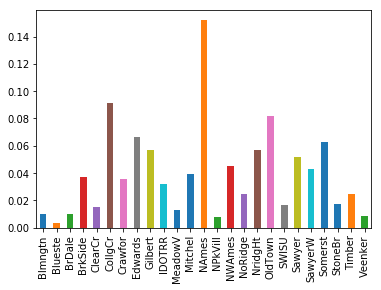

In [74]:
barplot(data,'Neighborhood')

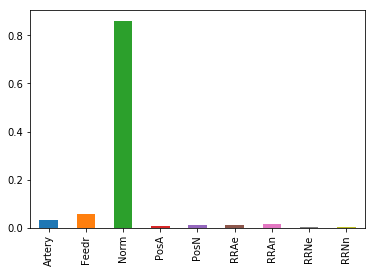

In [75]:
barplot(data,'Condition1')

In [76]:
missingRatio(data,'Condition1')

Condition1 missing ratio is:0.0


In [77]:
missingRatio(data,'Condition2')

Condition2 missing ratio is:0.0


#### 房子功能性[娱乐，加热等等]

Utilities，LotConfig，Heating，HeatingQC，Electrical，CentralAir，Functional，PoolQC，MiscFeature

1. Utilities,LotConfig,Heating,Electrical,CentralAir,Functional,MiscFeature

Utilities,删除特征

LotConfig,categorical

Heating,categorical

Electrical,categorical,中位数[众数]填充

CentralAir,categorical

Functional,categorical,中位数[众数]填充

MiscFeature

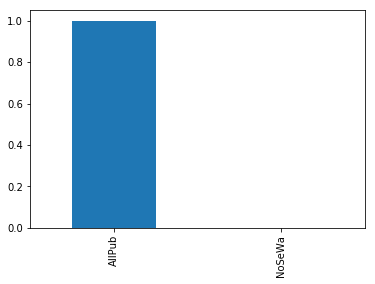

In [78]:
barplot(data,'Utilities')

In [79]:
missingRatio(data,'Utilities')

Utilities missing ratio is:0.0006851661527920521


In [80]:
data['Utilities'].value_counts()

AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64

In [81]:
len(data)

2919

Utilities特征太过于倾斜，倾向于删除这个特征，几乎99.9%的数据都是AllPub；


In [82]:
missingRatio(data,'LotConfig')

LotConfig missing ratio is:0.0


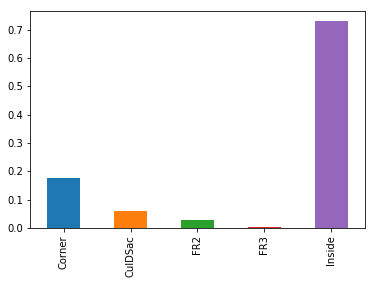

In [83]:
barplot(data,'LotConfig')

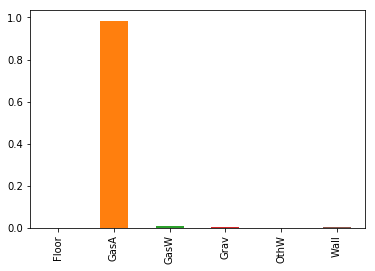

In [84]:
barplot(data,'Heating')

In [85]:
missingRatio(data,'Heating')

Heating missing ratio is:0.0


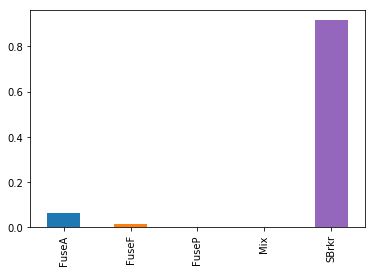

In [86]:
barplot(data,'Electrical')

In [87]:
missingRatio(data,'Electrical')

Electrical missing ratio is:0.00034258307639602604


In [88]:
missingRatio(data,'CentralAir')

CentralAir missing ratio is:0.0


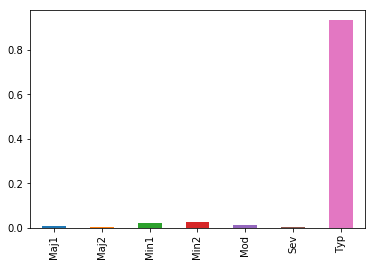

In [89]:
barplot(data,'Functional')

In [90]:
missingRatio(data,'Functional')

Functional missing ratio is:0.0006851661527920521


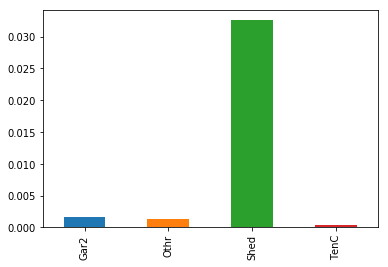

In [91]:
barplot(data,'MiscFeature')

In [92]:
missingRatio(data,'MiscFeature')

MiscFeature missing ratio is:0.9640287769784173


2. HeatingQC,PoolQC

HeatingQC,ordinal

PoolQC:None替换NA，ordinal

In [93]:
missingRatio(data,'HeatingQC')

HeatingQC missing ratio is:0.0


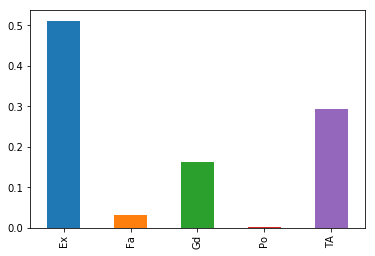

In [94]:
barplot(data,'HeatingQC')

In [95]:
missingRatio(data,'PoolQC')

PoolQC missing ratio is:0.9965741692360397


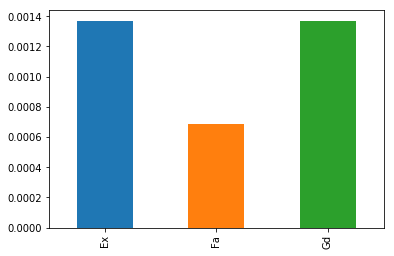

In [96]:
barplot(data,'PoolQC')

文本类型特征探索，处理方法确定成功。

接下来，看数值类型数据处理方法




### 数值性数据

['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
       'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars',
       'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr', 'LotArea',
       'LotFrontage', 'LowQualFinSF', 'MSSubClass', 'MasVnrArea', 'MiscVal',
       'MoSold', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'PoolArea',
       'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt',
       'YearRemodAdd', 'YrSold']
       
特征分类：

需要转换成类别属性[年份等]：GarageYrBlt，MSSubClass，MoSold，YearBuilt，YearRemodAdd，YrSold，[OverallCond，OverallQual]，


面积类：1stFlrSF，2ndFlrSF，3SsnPorch，BsmtFinSF1，BsmtFinSF2，EnclosedPorch，GarageArea，GrLivArea，KitchenAbvGr，
LotArea，LotFrontage，LowQualFinSF，MasVnrArea，OpenPorchSF,PoolArea,ScreenPorch,TotalBsmtSF,WoodDeckSF

个数类：BedroomAbvGr，BsmtFullBath，BsmtHalfBath，BsmtUnfSF，Fireplaces，FullBath，GarageCars，HalfBath,TotRmsAbvGrd,


待定：MiscVal

In [97]:
numFeats

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
       'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars',
       'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr', 'LotArea',
       'LotFrontage', 'LowQualFinSF', 'MSSubClass', 'MasVnrArea', 'MiscVal',
       'MoSold', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'PoolArea',
       'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt',
       'YearRemodAdd', 'YrSold'],
      dtype='object')

In [98]:
'BedroomAbvGr' in train.columns

True

先看看数值型特征缺失情况如何：

In [99]:
a = data[numFeats].isnull().sum()
(a[a>0]/len(data)).sort_values(ascending=False)

LotFrontage     0.166495
GarageYrBlt     0.054471
MasVnrArea      0.007879
BsmtHalfBath    0.000685
BsmtFullBath    0.000685
TotalBsmtSF     0.000343
GarageCars      0.000343
GarageArea      0.000343
BsmtUnfSF       0.000343
BsmtFinSF2      0.000343
BsmtFinSF1      0.000343
dtype: float64

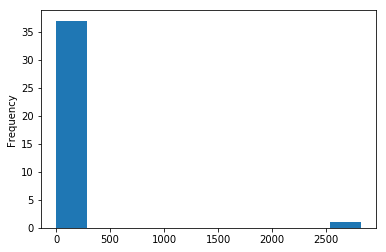

In [100]:
data['MiscVal'].value_counts().sort_index().plot.hist()

In [101]:
data['MiscVal'].value_counts().sort_index()

0        2816
54          1
80          1
300         1
350         1
400        18
420         1
450         9
455         1
460         1
480         2
490         1
500        13
560         1
600         8
620         1
650         3
700         7
750         1
800         1
900         1
1000        1
1150        1
1200        3
1300        1
1400        1
1500        3
1512        1
2000        7
2500        2
3000        2
3500        1
4500        2
6500        1
8300        1
12500       1
15500       1
17000       1
Name: MiscVal, dtype: int64

1. 转成类别型特征

GarageYrBlt，MSSubClass，MoSold，YearBuilt，YearRemodAdd，YrSold，[OverallCond，OverallQual]，

In [102]:
def histplot(df, col):
    df[col].sort_values().sort_index().plot.hist()

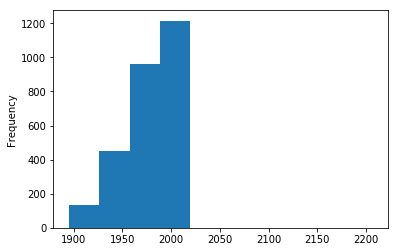

In [103]:
histplot(data,'GarageYrBlt')

In [104]:
def chgType(df,cols):
    for col in cols:
        df[col] = df[col].astype('str')

In [105]:
cols = ['GarageYrBlt','MSSubClass','MoSold','YearBuilt','YearRemodAdd','YrSold']

In [106]:
chgType(data,cols)

In [107]:
for col in numFeats:
    missingRatio(data,col)

1stFlrSF missing ratio is:0.0
2ndFlrSF missing ratio is:0.0
3SsnPorch missing ratio is:0.0
BedroomAbvGr missing ratio is:0.0
BsmtFinSF1 missing ratio is:0.00034258307639602604
BsmtFinSF2 missing ratio is:0.00034258307639602604
BsmtFullBath missing ratio is:0.0006851661527920521
BsmtHalfBath missing ratio is:0.0006851661527920521
BsmtUnfSF missing ratio is:0.00034258307639602604
EnclosedPorch missing ratio is:0.0
Fireplaces missing ratio is:0.0
FullBath missing ratio is:0.0
GarageArea missing ratio is:0.00034258307639602604
GarageCars missing ratio is:0.00034258307639602604
GarageYrBlt missing ratio is:0.0
GrLivArea missing ratio is:0.0
HalfBath missing ratio is:0.0
KitchenAbvGr missing ratio is:0.0
LotArea missing ratio is:0.0
LotFrontage missing ratio is:0.16649537512846865
LowQualFinSF missing ratio is:0.0
MSSubClass missing ratio is:0.0
MasVnrArea missing ratio is:0.0078794107571086
MiscVal missing ratio is:0.0
MoSold missing ratio is:0.0
OpenPorchSF missing ratio is:0.0
OverallCond

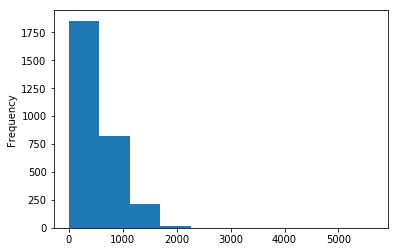

In [108]:
histplot(data,'BsmtFinSF1')

面积类特征：可以用均值填充；BsmtFinSF1，BsmtFinSF2，BsmtUnfSF,LotFrontage,MasVnrArea,TotalBsmtSF

数目类特征：可以用0填充；BsmtFullBath,BsmtHalfBath,GarageArea,GarageCars[没有车库],

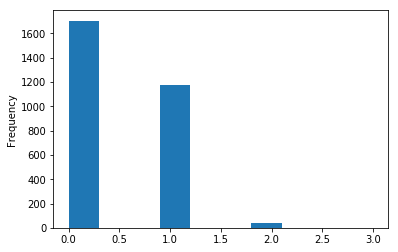

In [109]:
histplot(data,'BsmtFullBath')

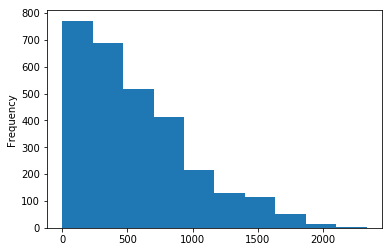

In [110]:
histplot(data,'BsmtUnfSF')

In [111]:
missingRatio(data,'GarageYrBlt')

GarageYrBlt missing ratio is:0.0


In [112]:
len(data['GarageYrBlt'])

2919

In [113]:
len(data)

2919

### 查看特征间关系

先看看协方差矩阵

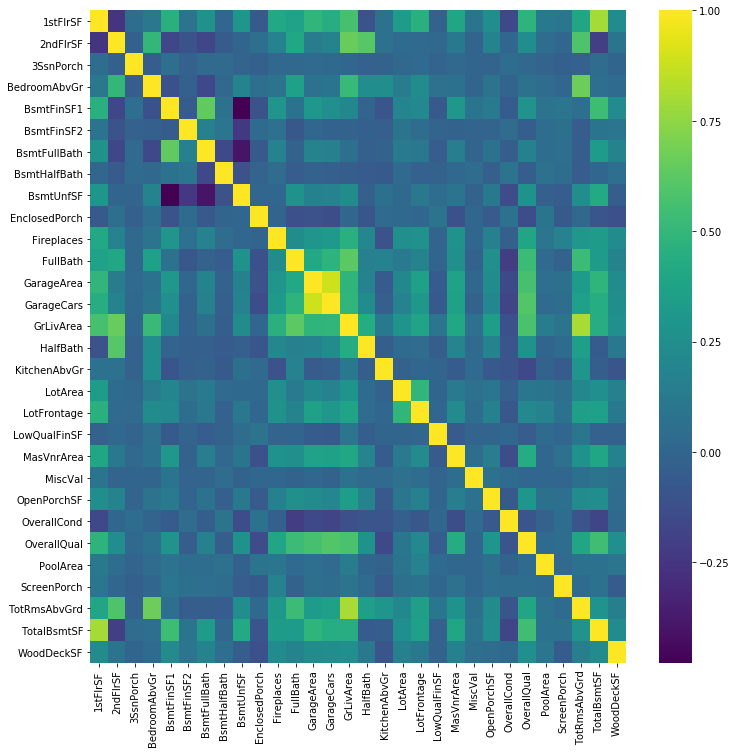

In [114]:
corr = data.corr()
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
sns.heatmap(corr,cmap=colormap)

看看与SalePrice相关的相关系数:
这个只能从训练集上来看了，所以只调用train，不能用data[data里把标签给删了]

In [118]:
# Adding total sqfootage feature 添加一个新特征：总面积
data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']

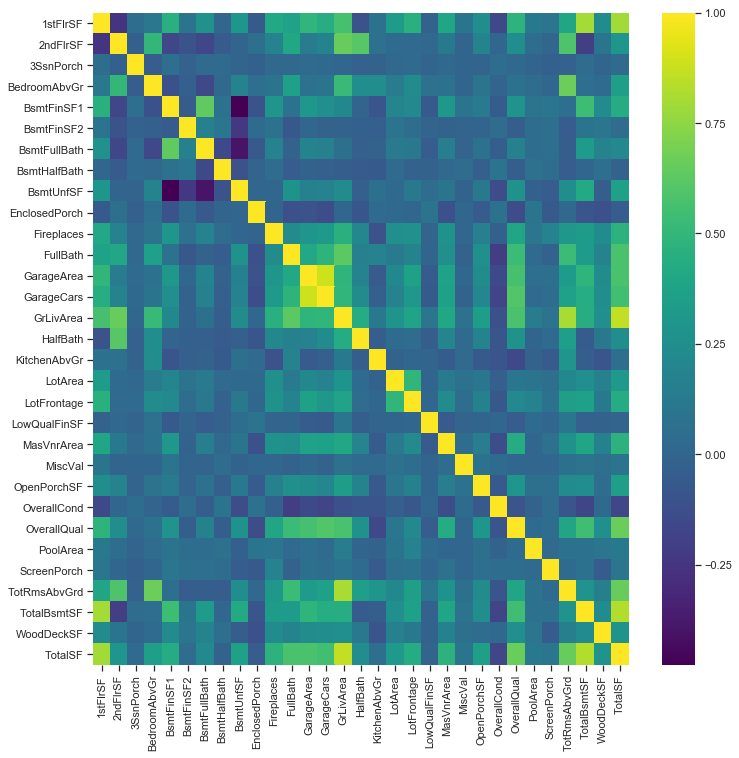

In [120]:
corr = data.corr()
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
sns.heatmap(corr,cmap=colormap)

In [121]:
train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']

In [122]:
train.corr()['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
TotalSF          0.782260
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr

看相关性在0.5以上的与标签SalePrice之间的散点图：

OverallQual      0.790982

GrLivArea        0.708624

GarageCars       0.640409

GarageArea       0.623431

TotalBsmtSF      0.613581

1stFlrSF         0.605852

FullBath         0.560664

TotRmsAbvGrd     0.533723

YearBuilt        0.522897

YearRemodAdd     0.507101

In [123]:
cols = train.corr()['SalePrice'].sort_values(ascending=False).index[:6]

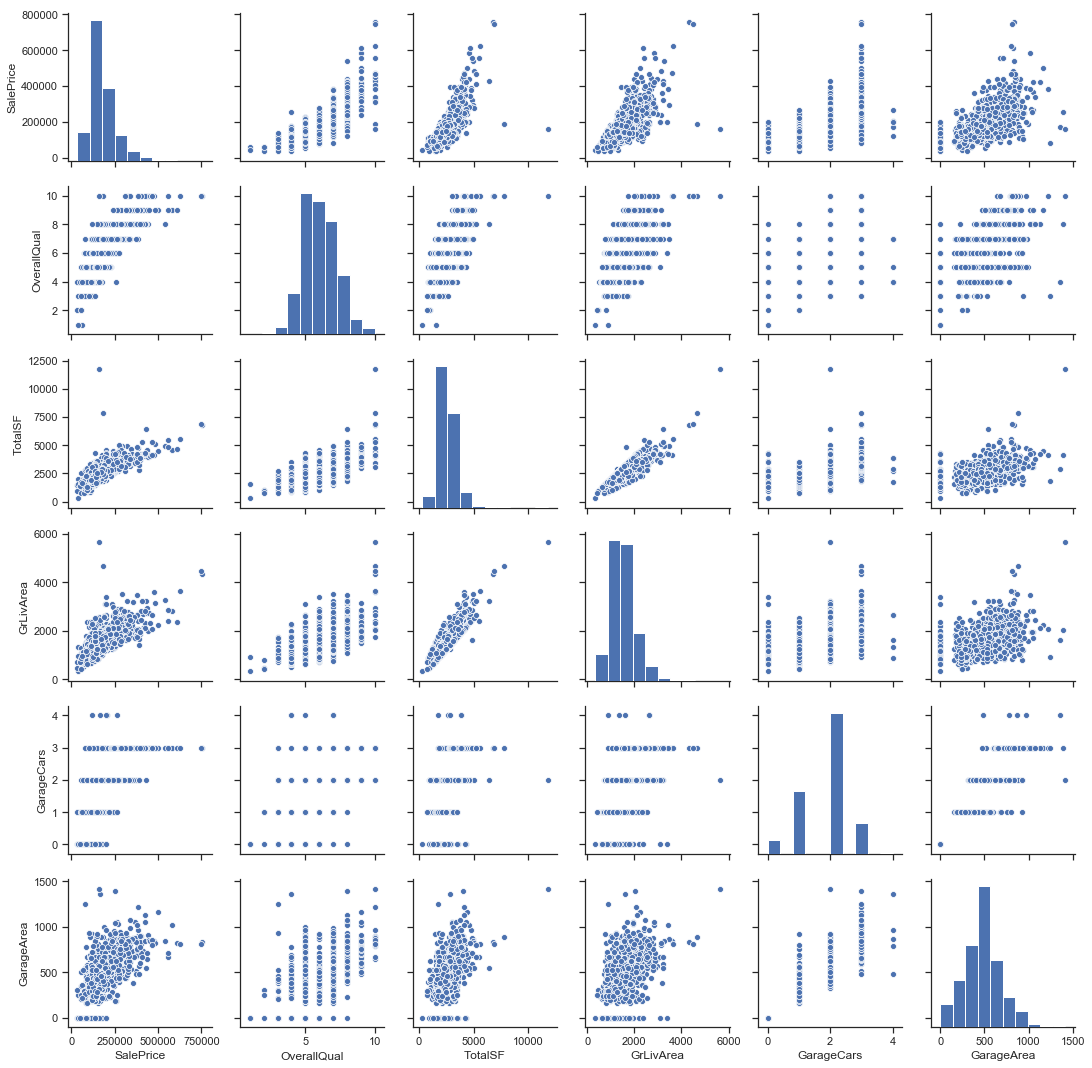

In [124]:
sns.set(style="ticks")
sns.pairplot(train[cols])

从上图可以看出与`SalePrice`相关的几个特征，几乎都成正相关。

单独看’GrLivArea‘,'TotalBsmtSF'，因为这两个图里面有几个似乎是离群点的数据

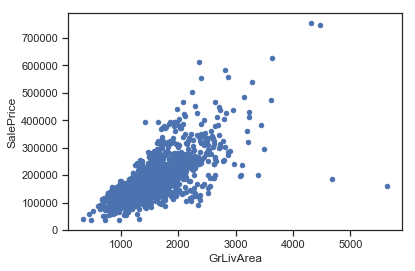

In [125]:
train.plot.scatter(x='GrLivArea',y='SalePrice')

居住面积越大，售价越高；而两个点GrLivArea>4000,价格确低于30000

In [126]:
#筛选出这两条记录
train[(train['GrLivArea']>4000) & (train['SalePrice']< 300000)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSF
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,NaN,NaN,NaN,0,10,2007,New,Partial,184750,7814
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,Gd,NaN,NaN,0,1,2008,New,Partial,160000,11752


In [127]:
train = train.drop(523)

In [128]:
train[train['Id']==524]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSF


In [129]:
train = train.drop(1298)

In [130]:
train[train['Id'] == 1299]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSF


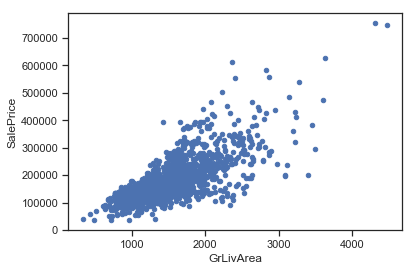

In [131]:
train.plot.scatter(x='GrLivArea',y='SalePrice')

**TotalBsmtSF**

也有一个离群点

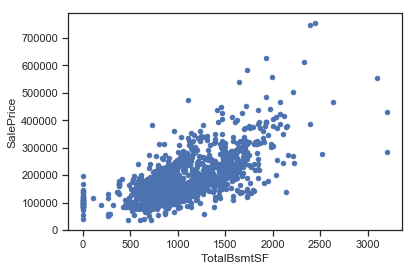

In [132]:
train.plot.scatter(x='TotalBsmtSF',y='SalePrice')

没有离群点是因为：GrLivArea处理过程中，把那条记录给删除了。

## Prepare the Data

1. Data cleaning:
    - Fix or remove outliners(optional).
    - Fill in missing values(e.g., with zero,mean,median...) or drop their rows(or columns).
2. Feature selection(optional):
    - Drop the attributes that provide no useful information for the task.
3. Feature engineering, where appropriate:
    - Discretize continuous feature.
    - Decompose features(e.g.,categorical, date/time,etc.)
    - Add promising transformations of features(e.g., log(x),sqrt(x),x^2,etc.)
    - Aggregate features into promising new feature.
4. Feature scaling: standardize or normalize features.

#### Data Cleaning

先把离群点处理掉；然后再将train、test连接起来，一块处理。

In [133]:
train = train_df.copy()
test = test_df.copy()


Ids = test['Id']


**处理离群点**

In [134]:
train[(train['GrLivArea']>4000) & (train['SalePrice']< 300000)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


In [135]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']< 300000)].index)

In [136]:
# 看看是否删除成功
train[(train['Id'] == 524) | (train['Id'] == 1299)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [137]:
y = train['SalePrice']
logy = np.log1p(y)

In [138]:
print(logy.shape)

(1458,)


In [139]:
data = pd.concat([train,test],axis=0)

In [140]:
data = data.drop(['Id','SalePrice'],axis=1)

In [141]:
len(data.columns)

79

In [142]:
data.sample(5)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
55,1425,0,407,NaN,3,1Fam,TA,No,490.0,0.0,...,WD,0,Pave,7,1425.0,AllPub,0,1964,1964,2008
1081,768,768,0,NaN,3,1Fam,TA,Mn,0.0,0.0,...,WD,0,Pave,6,768.0,AllPub,0,2005,2005,2007
1438,1491,0,0,NaN,3,1Fam,TA,No,0.0,0.0,...,WD,0,Pave,7,1491.0,AllPub,120,2001,2001,2006
696,1626,0,0,NaN,3,1Fam,TA,No,1271.0,0.0,...,WD,0,Pave,7,1602.0,AllPub,424,1994,1994,2008
1082,936,0,0,NaN,2,1Fam,TA,Gd,936.0,0.0,...,WD,0,Pave,4,936.0,AllPub,405,1967,1967,2007


**添加一个新特征：有关面积**

因为面积是方法相当重要的一个特征；

In [143]:
# Adding total sqfootage feature 添加一个新特征：总面积=地下室面积+1楼面积+2楼面积
data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']

1. 现将几个Numeric特征转换成categorical文本特征

cols = ['GarageYrBlt','MSSubClass','MoSold','YearBuilt','YearRemodAdd','YrSold']

In [144]:
cols = ['GarageYrBlt','MSSubClass','MoSold','YearBuilt','YearRemodAdd','YrSold']
chgType(data,cols)

2. 先填补空缺；然后再分开处理

In [145]:
a = data.isnull().sum()
b = (a[a>0].sort_values(ascending=False))
c = ((a[a>0]/len(data)).sort_values(ascending=False))
df = pd.concat([b,c],axis=1,keys=['Count','Percentage'])
df

,Count,Percentage
PoolQC,2908,0.996915
MiscFeature,2812,0.964004
Alley,2719,0.932122
Fence,2346,0.804251
FireplaceQu,1420,0.486802
LotFrontage,486,0.166610
GarageQual,159,0.054508
GarageFinish,159,0.054508
GarageCond,159,0.054508
GarageType,157,0.053822


根据处理方法划分特征集：

0填充：GarageArea BsmtFullBath BsmtHalfBath GarageCars
均值填充：BsmtFinSF1 BsmtFinSF2 LotFrontage MasVnrArea TotalBsmtSF BsmtUnfSF
众数填充：Exterior1st Exterior2nd SaleType MSZoning Electrical Functional
’None‘填充：MasVnrType BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2 KitchenQual FireplaceQu GarageType GarageFinish GarageQual GarageCond Fence Alley PoolQC Utilities

In [148]:
colsZero = ['GarageArea','BsmtFullBath','BsmtHalfBath','GarageCars']
colsMean = ['BsmtFinSF1', 'BsmtFinSF2', 'LotFrontage', 'MasVnrArea', 'TotalBsmtSF','BsmtUnfSF','TotalSF']
colsMode = ['MSZoning', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Electrical', 'Functional']
colsNone = ['MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',\
            'KitchenQual','FireplaceQu' ,'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','Fence' ,'Alley',\
            'PoolQC','MiscFeature']

colDel = 'Utilities'# 特征集太过于集中99.9%

print(len(df.index) == (len(colsZero) + len(colsMean) + len(colsMode) + len(colsNone) +1))

True


In [149]:
def fillZero(df,cols):
    for col in cols:
        df[col].fillna(0,inplace=True)

def fillMean(df,cols):#都用全部数据的统计值：train + test；应该是只用train的；
    for col in cols:
        df[col].fillna(df[col].mean(),inplace=True)

def fillMode(df,cols):
    for col in cols:
        df[col].fillna(df[col].mode()[0],inplace=True)

def fillNone(df,cols):
    for col in cols:
        df[col].fillna('None',inplace=True)

fillZero(data,colsZero)
fillMean(data,colsMean)
fillMode(data,colsMode)
fillNone(data,colsNone)

In [150]:
#看看数据集是否还有空缺值

a = data.isnull().sum()
a[a>0]

Utilities    2
dtype: int64

**处理Utilities特征**

直接删除，因为特征取值太过于集中

In [151]:
data.drop('Utilities',axis=1,inplace=True)

In [152]:
data.sample(5)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,TotalSF
1268,720,720,0,None,4,1Fam,TA,No,360.0,0.0,...,WD,0,Pave,7,720.0,0,1964,1964,2006,2160.0
895,983,813,0,None,4,1Fam,TA,No,400.0,0.0,...,WD,0,Pave,8,780.0,0,1963,1963,2008,2576.0
519,1367,0,0,None,2,TwnhsE,TA,No,20.0,0.0,...,WD,0,Pave,6,1367.0,0,2005,2005,2008,2734.0
606,1764,0,0,None,4,1Fam,None,None,0.0,0.0,...,WD,0,Pave,7,0.0,0,1957,1982,2008,1764.0
561,1430,0,0,None,3,1Fam,TA,Av,800.0,0.0,...,WD,0,Pave,6,1430.0,117,1974,1974,2008,2860.0


空缺值特征处理完成！！！

2. 划分数值型特征、文本特征；分别处理，最后拼接

In [153]:
cateFeats = data.select_dtypes(include=[object]).columns
numFeats = data.select_dtypes(include=[np.float64,np.int64]).columns

print("data featuers lengths:{},cates:{},nums:{}".format(len(data.columns),len(cateFeats),len(numFeats)))

data featuers lengths:79,cates:48,nums:31


In [154]:
cateFeats

Index(['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd',
       'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'Heating',
       'HeatingQC', 'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope',
       'LotConfig', 'LotShape', 'MSSubClass', 'MSZoning', 'MasVnrType',
       'MiscFeature', 'MoSold', 'Neighborhood', 'PavedDrive', 'PoolQC',
       'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street',
       'YearBuilt', 'YearRemodAdd', 'YrSold'],
      dtype='object')

In [155]:
ordCols = ['ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','KitchenQual',\
           'FireplaceQu','GarageFinish','GarageQual','GarageCond','Fence','HeatingQC','PoolQC']
#'GarageYrBlt','MoSold','YearBuilt','YearRemodAdd','YrSold' :用dummies处理吧
oneHotCols = [col for col in cateFeats if col not in ordCols]
numCols = numFeats
print(len(ordCols))
print(len(oneHotCols))
print(len(numCols))

15
33
31


### 数据处理
ordCols LabelEncoder处理-----手动处理

oneHotCols OneHotEncoder处理-----dummies更方便

numCols 先检查skewness，纠正后，再StandardScaler处理

In [156]:
ordData = data[ordCols]
oneHotData = data[oneHotCols]
numData = data[numCols]

**LabelEncoder处理** [失败]

In [157]:
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder,StandardScaler

In [360]:
labelencoder = LabelEncoder()#只能一次处理一个特征；不能全部处理，否则会出现错误：ValueError: bad input shape (2917, 2

ValueError: bad input shape (2917, 20)

In [363]:
ordencoder = OrdinalEncoder()
ordDataMat = ordencoder.fit_transform(ordData)#结果不可取，类别顺序出错，默认对字符型类别做sorted排序，确定类别间的顺序关系
#打算对

In [366]:
ordDataMat

array([[  2.,   4.,   2., ..., 110.,  53.,   2.],
       [  3.,   4.,   2., ...,  83.,  26.,   1.],
       [  2.,   4.,   2., ..., 108.,  52.,   2.],
       ...,
       [  3.,   4.,   4., ...,  67.,  46.,   0.],
       [  3.,   4.,   2., ...,  99.,  42.,   0.],
       [  3.,   4.,   2., ..., 100.,  44.,   0.]])

In [365]:
ordencoder.categories_

[array(['Ex', 'Fa', 'Gd', 'TA'], dtype=object),
 array(['Ex', 'Fa', 'Gd', 'Po', 'TA'], dtype=object),
 array(['Ex', 'Fa', 'Gd', 'None', 'TA'], dtype=object),
 array(['Fa', 'Gd', 'None', 'Po', 'TA'], dtype=object),
 array(['Av', 'Gd', 'Mn', 'No', 'None'], dtype=object),
 array(['ALQ', 'BLQ', 'GLQ', 'LwQ', 'None', 'Rec', 'Unf'], dtype=object),
 array(['ALQ', 'BLQ', 'GLQ', 'LwQ', 'None', 'Rec', 'Unf'], dtype=object),
 array(['Ex', 'Fa', 'Gd', 'None', 'TA'], dtype=object),
 array(['Ex', 'Fa', 'Gd', 'None', 'Po', 'TA'], dtype=object),
 array(['Fin', 'None', 'RFn', 'Unf'], dtype=object),
 array(['Ex', 'Fa', 'Gd', 'None', 'Po', 'TA'], dtype=object),
 array(['Ex', 'Fa', 'Gd', 'None', 'Po', 'TA'], dtype=object),
 array(['GdPrv', 'GdWo', 'MnPrv', 'MnWw', 'None'], dtype=object),
 array(['Ex', 'Fa', 'Gd', 'Po', 'TA'], dtype=object),
 array(['Ex', 'Fa', 'Gd', 'None'], dtype=object),
 array(['1895.0', '1896.0', '1900.0', '1906.0', '1908.0', '1910.0',
        '1914.0', '1915.0', '1916.0', '1917.0', '

#### 还是用原来的对应方法

因为使用labelencoder或者是ordinalencoder，学习特征顺序时，会对字符串特征对sorted排序，这样就打乱了定义的顺序。[我猜测可能会对模型造成影响]。

In [158]:
qual5toCat = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0} # ExterQual ExterCond HeatingQC KitchenQual
# 6 FireplaceQu  GarageQual GarageCond
qual6toCatBsmt = {'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5} # BsmtQual BsmtCond
qual7toCat = {'None':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6}# BsmtFinType1 BsmtFinType2

mapBsmtExposure = {'None':0,'No':1,'Mn':2,'Av':3,'Gd':4} # BsmtExposure
mapPoolQC = {'Ex':4,'Gd':3,'TA':2,'Fa':1,'None':0}#PoolQC
# mapFunctional = {'Sal':0,'Sev':1,'Maj2':2,'Maj1':3,'Mod':4,'Min2':5,'Min1':6,'Typ':7}
# mapGarageType = {'None':0,'Detchd':1,'CarPort':2,'BuiltIn':3,'Basment':4,'Attchd':5,'2Types':6}
mapGarageFinish = {'None':0,'Unf':1,'RFn':2,'Fin':3}
mapFence = {'None':0,'MnWw':1,'GdWo':2,'MnPrv':3,'GdPrv':4}
# mapMiscFeature = {'None':0,'TenC':1,'Shed':2,'Othr':3,'Gar2':4,'Elev':5}

feats1 = ['ExterQual','ExterCond','HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond']
feats2 = ['BsmtQual','BsmtCond']
feats3 = ['BsmtFinType1','BsmtFinType2']

ordCols = ['ExterQual','ExterCond','HeatingQC','KitchenQual','FireplaceQu','BsmtQual','BsmtCond','BsmtFinType1','BsmtFinType2',\
          'GarageQual','GarageCond','BsmtExposure','GarageFinish','Fence','PoolQC']

def transformDF(df):
    for feature in feats1:
        df = df.replace({feature: qual5toCat})
    for feature in feats2:
        df = df.replace({feature: qual6toCatBsmt})
    for feature in feats3:
        df = df.replace({feature: qual7toCat})
    df = df.replace({'BsmtExposure':mapBsmtExposure})
    df = df.replace({'PoolQC':mapPoolQC})
#     df = df.replace({'Functional':mapFunctional})
#     df = df.replace({'GarageType':mapGarageType})
    df = df.replace({'GarageFinish':mapGarageFinish})
    df = df.replace({'Fence':mapFence})
#     df = df.replace({'MiscFeature':mapMiscFeature})
    return df

ordData = transformDF(ordData)

In [159]:
ordData.shape

(2917, 15)

#### Dummies


In [160]:
oneHotData = pd.get_dummies(oneHotData)

In [161]:
oneHotData.sample(5)

,Alley_Grvl,Alley_None,Alley_Pave,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,CentralAir_N,CentralAir_Y,...,YearRemodAdd_2006,YearRemodAdd_2007,YearRemodAdd_2008,YearRemodAdd_2009,YearRemodAdd_2010,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
1178,0,1,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
49,0,1,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
781,0,1,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
81,0,1,0,0,0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
324,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


#### Numeric

先skew，纠正后；StandardScaler


数字特征在进行StandardScaler之前，先看看特征的skew状态，是否符合正态分布。

scipy.stats.skew 计算偏态，如果为0，表示符合正态分布

In [162]:
skewed_feats = numData.apply(lambda x: skew(x)).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
KitchenAbvGr,4.300550
BsmtFinSF2,4.144394
EnclosedPorch,4.002344
ScreenPorch,3.945101
BsmtHalfBath,3.929996


In [163]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    numData[feat] = boxcox1p(numData[feat], lam)

There are 31 skewed numerical features to Box Cox transform


Box-Cox变换是Box和Cox在1964年提出的一种广义幂变换方法，是**统计建模中常用的一种数据变换，用于连续的响应变量不满足正态分布的情况。**Box-Cox变换之后，可以一定程度上减小不可观测的误差和预测变量的相关性。Box-Cox变换的主要特点是引入一个参数，通过数据本身估计该参数进而确定应采取的数据变换形式，**Box-Cox变换可以明显地改善数据的正态性、对称性和方差相等性，对许多实际数据都是行之有效的**.

boxcox转换之后，是不是不用进行StandardScaler处理了？

In [194]:
scaler = StandardScaler()
numData = scaler.fit_transform(numData)

In [195]:
numData

array([[-0.78620107,  1.21533427, -0.11235155, ..., -0.07204674,
        -0.93350228,  0.15772454],
       [ 0.40899067, -0.85961458, -0.11235155, ...,  0.42354565,
         1.33349299,  0.10384929],
       [-0.56945926,  1.22215402, -0.11235155, ...,  0.01782636,
        -0.93350228,  0.33205632],
       ...,
       [ 0.31229779, -0.85961458, -0.11235155, ...,  0.38345145,
         1.61708284,  0.00439405],
       [-0.40886733, -0.85961458, -0.11235155, ...,  0.00688814,
         0.63177409, -0.83231733],
       [-0.32811983,  1.29530987, -0.11235155, ...,  0.117899  ,
         1.07704845,  0.6700646 ]])

In [196]:
type(numData)

numpy.ndarray

In [197]:
numData.shape

(2917, 31)

In [198]:
numData = pd.DataFrame(numData,index=ordData.index,columns=numFeats)
#必须指定index，而且和之前的index保持相同，否则concat时会出错

In [199]:
print(ordData.shape,oneHotData.shape,numData.shape)

(2917, 15) (2917, 501) (2917, 31)


In [200]:
data = pd.concat([ordData,oneHotData,numData],axis=1)

In [201]:
data.shape

(2917, 547)

### 划分训练集和测试集

数据处理完成

In [202]:
train.shape

(1458, 81)

In [203]:
trainScaled = data[:len(train)]
testScaled = data[len(train):]

In [204]:
print(trainScaled.shape,testScaled.shape)

(1458, 547) (1459, 547)


In [205]:
print(test.shape)

(1459, 80)


In [282]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)#保留原信息的百分比
pcaTrain = pca.fit_transform(trainScaled)
pcaTest = pca.transform(testScaled)

In [283]:
pcaTrain.shape

(1458, 105)

In [284]:
pcaTest.shape

(1459, 105)

###  建模

In [285]:
from sklearn.model_selection import cross_val_score

def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

In [286]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso,SGDRegressor,ElasticNet, BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR,LinearSVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

linReg = LinearRegression()
ridge = Ridge()
lasso = Lasso()
sgdr = SGDRegressor()
rfr = RandomForestRegressor()
svr = SVR()
linsvr = LinearSVR()

names = ["LR", "Ridge", "Lasso", "RF", "SGD","SVR", "LinSVR"]
models = [linReg,ridge,lasso,rfr,sgdr,svr,linsvr]

for name, model in zip(names, models):
    score = rmse_cv(model, pcaTrain, logy)
    print("{}: {:.6f}, {:.4f}".format(name,score.mean(),score.std()))

LR: 0.121521, 0.0038
Ridge: 0.121396, 0.0039
Lasso: 0.353012, 0.0193
RF: 0.156296, 0.0043
SGD: 0.198549, 0.0114
SVR: 0.134842, 0.0110
LinSVR: 0.123213, 0.0041


+StandardScaler: 结果好一点 0.95
LR: 0.121521, 0.0038
Ridge: 0.121396, 0.0039
Lasso: 0.353012, 0.0193
RF: 0.154929, 0.0086
SGD: 0.210274, 0.0079
SVR: 0.134842, 0.0110
LinSVR: 0.123683, 0.0051

+StandardScaler: 结果好一点 0.85

LR: 0.257501, 0.0997
Ridge: 0.130512, 0.0083
Lasso: 0.353012, 0.0193
RF: 0.164476, 0.0068
SGD: 0.222406, 0.0125
SVR: 0.118071, 0.0060
LinSVR: 0.151296, 0.0070

用没经过PCA处理的特征看看：
LR: 553201756.209779, 466825500.0206
Ridge: 0.130044, 0.0082
Lasso: 0.399468, 0.0158
RF: 0.148049, 0.0055
SGD: 342883606468.619751, 134204531970.1509
SVR: 0.132991, 0.0050
LinSVR: 0.183416, 0.0486

pcaTrain：
LR: 0.261251, 0.1029
Ridge: 0.130485, 0.0083
Lasso: 0.337614, 0.0162
RF: 0.221375, 0.0091
SGD: 0.283497, 0.0323
SVR: 0.134307, 0.0055
LinSVR: 0.162313, 0.0085

LR: 0.302314, 0.1217

Ridge: 0.127601, 0.0085

Lasso: 0.358728, 0.0196

RF: 0.166624, 0.0048

SGD: 0.246059, 0.0184

SVR: 0.118177, 0.0057

LinSVR: 0.151619, 0.0121

In [287]:
lasso2 = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [288]:
names = ["Lasso", "ElasticNet", "GBoost", 'model_xgb']
models = [lasso2,ENet,GBoost,model_xgb]

for name, model in zip(names, models):
    score = rmse_cv(model, pcaTrain, logy)
    print("{}: {:.6f}, {:.4f}".format(name,score.mean(),score.std()))

Lasso: 0.120736, 0.0041
ElasticNet: 0.120795, 0.0041
GBoost: 0.150713, 0.0143
model_xgb: 0.131193, 0.0061


0.95信息：
Lasso: 0.120736, 0.0041
ElasticNet: 0.120795, 0.0041
GBoost: 0.150713, 0.0143
model_xgb: 0.131193, 0.0061

0.90信息：
Lasso: 0.123352, 0.0051
ElasticNet: 0.123366, 0.0051
GBoost: 0.142233, 0.0105
model_xgb: 0.127531, 0.0062

Lasso: 0.140030, 0.0085
ElasticNet: 0.141128, 0.0087
GBoost: 0.198773, 0.0159
model_xgb: 0.165277, 0.0098

In [289]:
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator,RegressorMixin,TransformerMixin,clone

class StackingAveragedModels(BaseEstimator,RegressorMixin,TransformerMixin):
    def __init__(self,base_models,meta_model,n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
    
    # 在clone模型上进行模型训练：保证不对原始模型造成影响；原始模型只是指定了一个模型类；
    def fit(self,X,y):
        self.base_models_ = [list() for x in self.base_models]#保存每个模型类下的n_folds个训练模型
        self.meta_model_ = clone(self.meta_model)
        Kfold = KFold(n_splits=self.n_folds,shuffle=True,random_state=42)
        
        #定义新特征保存矩阵：每个模型在n_folds-1个fold上训练，创建out-of-fold的预测结果，n_folds迭代结果后，out-of-fold预测结果
        #遍历所有训练集，形成新特征；最后n个模型的新特征在meta_model上训练即可；
        out_of_fold_predicts = np.zeros((X.shape[0], len(self.base_models)))
        
        for i, model in enumerate(self.base_models):#遍历所有模型，新特征维度 等于 模型的个数
            for train_index, holdout_index in Kfold.split(X,y):#对每个base模型进行训练，形成新特征
                instance = clone(model)
                self.base_models_[i].append(instance)
#                 print(self.base_models_[i])
                instance.fit(X[train_index],y.as_matrix()[train_index])
                y_pred = instance.predict(X[holdout_index])
                #第k次模型训练在留出折上的预测结果；n_folds遍历结果后，形成模型i的在训练集上的所有预测
                out_of_fold_predicts[holdout_index, i] = y_pred
        #在新特征上对meta_model进行训练
        self.meta_model_.fit(out_of_fold_predicts,y)
        
        return self
    
    #在对数据进行预测之前需要先将数据X转换过到新特征维度上，才能开始预测
    def predict(self,X):#axis=1 cross; axis=0 down
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)#对每行取平均；最后剩一列
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [ ]:
stacked_models = StackingAveragedModels(base_models=(ridge,sgdr,rfr,svr),meta_model=linReg)
score = rmse_cv(stacked_models,pcaTrain,logy)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

  Averaged base models score: 0.1185 (0.0049)

 Averaged base models score: 0.1205 (0.0068)
 Averaged base models score: 0.1207 (0.0068)

Averaged base models score: 0.1152 (0.0064)

In [260]:
stacked_models1 = StackingAveragedModels(base_models=(lasso2,ENet,GBoost,model_xgb),meta_model=svr)
score = rmse_cv(stacked_models1,pcaTrain,logy)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1177 (0.0062)



 Averaged base models score: 0.1330 (0.0071)
 Averaged base models score: 0.1359 (0.0070)


In [244]:
stacked_models2 = StackingAveragedModels(base_models=(lasso2,ENet,GBoost),meta_model=model_xgb)
score = rmse_cv(stacked_models2,pcaTrain,logy)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1228 (0.0057)



 Averaged base models score: 0.1389 (0.0117)

In [245]:
stacked_models.fit(pcaTrain, logy)
stacked_train_pred = stacked_models.predict(pcaTrain)
stacked_pred = stacked_models.predict(pcaTest)


In [229]:
df = pd.DataFrame({'Id':Ids,'SalePrice':np.expm1(stacked_pred)})
df.to_csv('./output/easyStack-1016add.csv',index=False)

Your submission scored 0.12361, which is an improvement of your previous score of 0.12506. Great job!

In [246]:
stacked_models2 = StackingAveragedModels(base_models=(lasso,ridge,svr),meta_model=model_xgb)
score = rmse_cv(stacked_models2,pcaTrain,logy)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1220 (0.0056)



In [261]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # 将原始模型clone一份，对克隆后模型进行训练、预测----保证不会影响到原始模型；毕竟这是一个求loss的函数，对原始数据影响越小越好
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # 训练cloned模型
        for model in self.models_:
            model.fit(X, y)

        return self
    
    # 对每个模型在数据集上做预测，然后对各个模型的得分结果取平均
    def predict(self, X):
        predictions = np.column_stack([#将1D数组按照列横向拼接---列变多了，要保证每个1D数组长度相同
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)    

In [262]:
averaged_models = AveragingModels(models = (ridge,rfr,linReg,linsvr))
score = rmse_cv(averaged_models,pcaTrain,logy)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1195 (0.0063)



 Averaged base models score: 0.1216 (0.0076)


In [263]:
averaged_models1 = AveragingModels(models = (lasso2,ridge,svr,model_xgb))
score = rmse_cv(averaged_models1,pcaTrain,logy)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1167 (0.0063)



In [273]:
averaged_models1.fit(pcaTrain,logy)
averaged_models1_train_pred = averaged_models1.predict(pcaTrain)
averaged_models1_test_pred = averaged_models1.predict(pcaTest)

 Averaged base models score: 0.1191 (0.0068)


In [264]:
stacked_models2 = StackingAveragedModels(base_models=(lasso,ridge,svr,model_xgb),meta_model=linsvr)

score = rmse_cv(stacked_models2,pcaTrain,logy)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1478 (0.0350)



In [265]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [268]:
stacked_models.fit(pcaTrain, logy)
stacked_train_pred = stacked_models.predict(pcaTrain)
stacked_pred = np.expm1(stacked_models.predict(pcaTest))
print(rmsle(logy, stacked_train_pred))

0.08924083657163547


In [269]:
model_xgb.fit(pcaTrain, logy)
xgb_train_pred = model_xgb.predict(pcaTrain)
xgb_pred = np.expm1(model_xgb.predict(pcaTest))
print(rmsle(logy, xgb_train_pred))

0.06139321712323554


In [270]:
df = pd.DataFrame({'Id':Ids,'SalePrice':xgb_pred})
df.to_csv('./output/xgb10-16.csv',index=False)

In [276]:
print('RMSLE score on train data:')
print(rmsle(logy,stacked_train_pred*0.60+xgb_train_pred*0.30 + averaged_models1_train_pred*0.10 ))


RMSLE score on train data:
0.078022071087322


In [277]:
ensemble = stacked_pred * 0.60 + xgb_pred*0.30 + averaged_models1_test_pred*0.10

In [279]:
ensemble

array([106657.69173096, 144149.19091848, 162606.6995982 , ...,
       148155.1175565 , 100072.97474946, 204372.62319528])

In [281]:
df = pd.DataFrame({'Id':Ids,'SalePrice':ensemble})
df.to_csv('./output/ensemble10-16.csv',index=False)#不好